In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import RMSprop, Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
df_test_１= pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
display(df_train.head())
display(df_test_１.head())

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [3]:
df_train["Sex"].value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

In [4]:
df_train['Sex'] = df_train['Sex'].map({
    'I': 0,
    'M': 1,
    'F': 2,
})
df_train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,2,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,2,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,0,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,1,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,0,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
# pyToch
# df_train['Rings'].nunique()
N_CLASSES = 30
N_CLASSES

30

In [6]:
torch.manual_seed(13)
np.random.seed(13)

In [7]:
EPOCHS = 10000
BATCH_SIZE = 32
LEARNING_RATE = 0.1
NUM_FEATURES = len(df_train.drop(['id', 'Rings'], axis=1).columns)


In [8]:
X = df_train.drop(['id', 'Rings'], axis=1).values
y = df_train['Rings'].values

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.4,shuffle=True)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
# Converting From Numpy Array To Torch Tensor
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [11]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [12]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=N_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=8, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=30, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
def train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):
    print("Begin training.")

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output_train = model(X_train.to(device))
        loss_train = criterion(output_train, y_train.to(device))
        loss_train.backward()
        optimizer.step()

        output_test = model(X_test)
        loss_test = criterion(output_test, y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In [14]:
train_losses = np.zeros(EPOCHS)
test_losses  = np.zeros(EPOCHS)

In [15]:
unique_count = len(np.unique(y_train))
print("Unique count:", unique_count)

Unique count: 28


In [16]:
train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, EPOCHS, train_losses, test_losses)

Begin training.
Epoch 50/10000, Train Loss: 1.7893, Test Loss: 1.7937
Epoch 100/10000, Train Loss: 1.7669, Test Loss: 1.7765
Epoch 150/10000, Train Loss: 1.7573, Test Loss: 1.7600
Epoch 200/10000, Train Loss: 1.7535, Test Loss: 1.7618
Epoch 250/10000, Train Loss: 1.7495, Test Loss: 1.7543
Epoch 300/10000, Train Loss: 1.7388, Test Loss: 1.7533
Epoch 350/10000, Train Loss: 1.7395, Test Loss: 1.7530
Epoch 400/10000, Train Loss: 1.7357, Test Loss: 1.7516
Epoch 450/10000, Train Loss: 1.7364, Test Loss: 1.7507
Epoch 500/10000, Train Loss: 1.7338, Test Loss: 1.7506
Epoch 550/10000, Train Loss: 1.7332, Test Loss: 1.7524
Epoch 600/10000, Train Loss: 1.7272, Test Loss: 1.7528
Epoch 650/10000, Train Loss: 1.7245, Test Loss: 1.7469
Epoch 700/10000, Train Loss: 1.7254, Test Loss: 1.7501
Epoch 750/10000, Train Loss: 1.7225, Test Loss: 1.7486
Epoch 800/10000, Train Loss: 1.7216, Test Loss: 1.7536
Epoch 850/10000, Train Loss: 1.7202, Test Loss: 1.7552
Epoch 900/10000, Train Loss: 1.7169, Test Loss: 1.

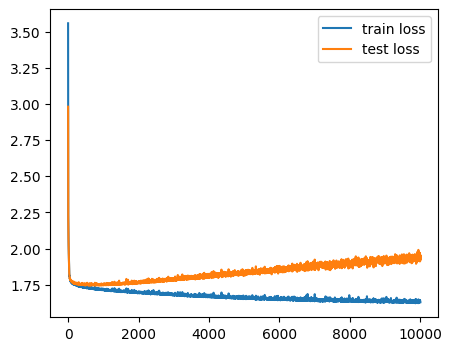

In [17]:
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [18]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train).to(device)
    predictions_test = model(X_test).to(device)

In [19]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr) != len(original_arr):
        return False
    pred_arr = pred_arr.cpu().numpy()
    original_arr = original_arr.cpu().numpy()
    final_pred = []
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [20]:
train_acc = get_accuracy_multiclass(predictions_train, y_train)
test_acc  = get_accuracy_multiclass(predictions_test, y_test)

print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 38.081
Test Accuracy: 34.244


In [21]:
df_test = df_test_１.copy()

In [22]:
df_test['Sex'] = df_test['Sex'].map({
    'I': 0,
    'M': 1,
    'F': 2,
})

In [23]:
test_features = df_test.drop(['id'], axis=1).values
test_features = torch.FloatTensor(test_features).to(device)

In [24]:
predictions_final = model(test_features).to(device)

In [25]:
predicted_classes = torch.argmax(predictions_final, dim=1).cpu()

In [26]:
final_output = pd.concat([pd.DataFrame(df_test['id']), pd.DataFrame(predicted_classes)], axis=1)
final_output.rename(columns={0: 'NObeyesdad'}, inplace=True)

final_output.head()

,id,NObeyesdad
0,90615,9
1,90616,9
2,90617,9
3,90618,9
4,90619,7


In [27]:
final_output.to_csv('submission.csv', index=False)